# Result processing

# Results from binary classifier

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
import pickle
import seaborn as sns

In [26]:
noise_type_translation = {
    'sap_noise': 'SAP Noise',
    'vertical_noise': 'Vertical Noise',
    'periodic_noise': 'Periodic Noise',
    'diagonal_noise': 'Diagonal Noise',
}

def visualize_classifier(classifier_info):
    """
    Compare two masks to check how they differ.
    images: first mask, second mask, and the difference between them.
    
    Args:
        predicted_mask (list): The first mask to compare.
        real_mask (list): The second mask to compare.
    """
    # using matplotlib to visualize the masks
    predicted_mask = classifier_info['predicted_mask']
    real_mask = classifier_info['mask']
    noise = classifier_info['noise_type']
    accuracy = classifier_info['accuracy']
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    # fig.suptitle(f'Best classifier for {noise_type_translation[noise]}, Accuracy: {accuracy:.4f}')
    ax1.imshow(predicted_mask, cmap='gray')
    ax1.set_title(f'Predicted Mask')
    ax1.axis('off')
    ax2.imshow(real_mask, cmap='gray')
    ax2.set_title('Real Mask')
    ax2.axis('off')
    ax3.imshow(abs(real_mask - predicted_mask), cmap='gray') # might not be totally correct TODO (one sided difference)
    ax3.set_title('Absolute Difference')
    ax3.axis('off')
    plt.tight_layout()
    plt.rc('axes', titlesize=30)
    plt.show()

Classifier 1 - Accuracy: 0.99957275390625, Seed: 2291659237, Noise Type: vertical_noise, Window Type: window_3x3


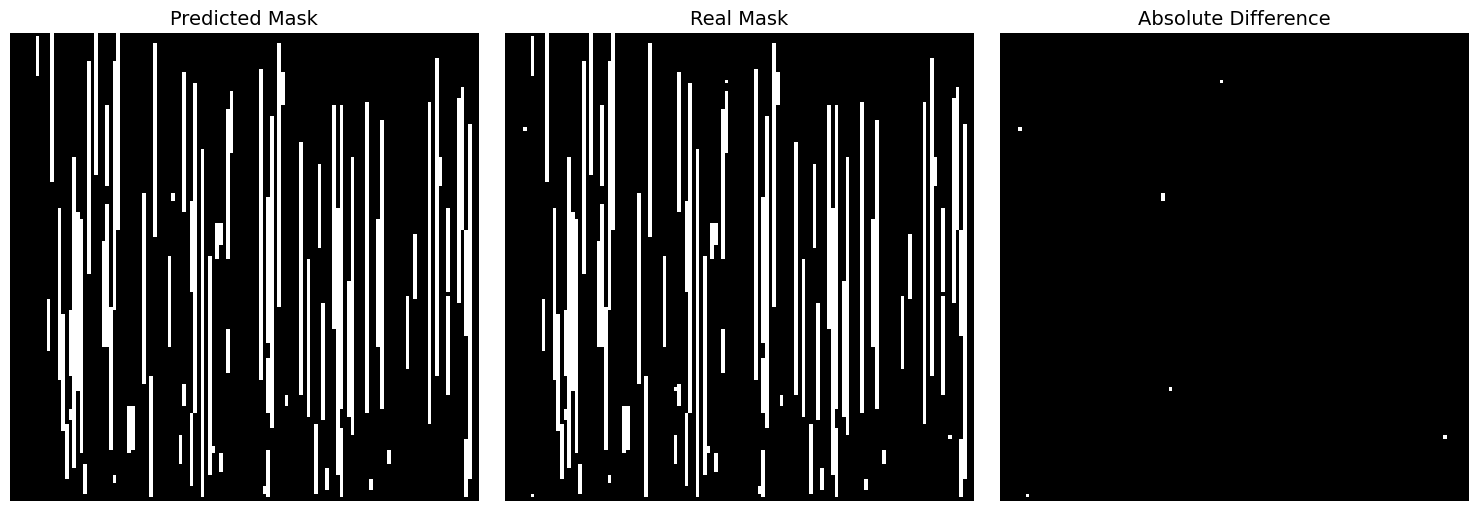

Classifier 2 - Accuracy: 0.99957275390625, Seed: 2441695047, Noise Type: diagonal_noise, Window Type: window_3x3


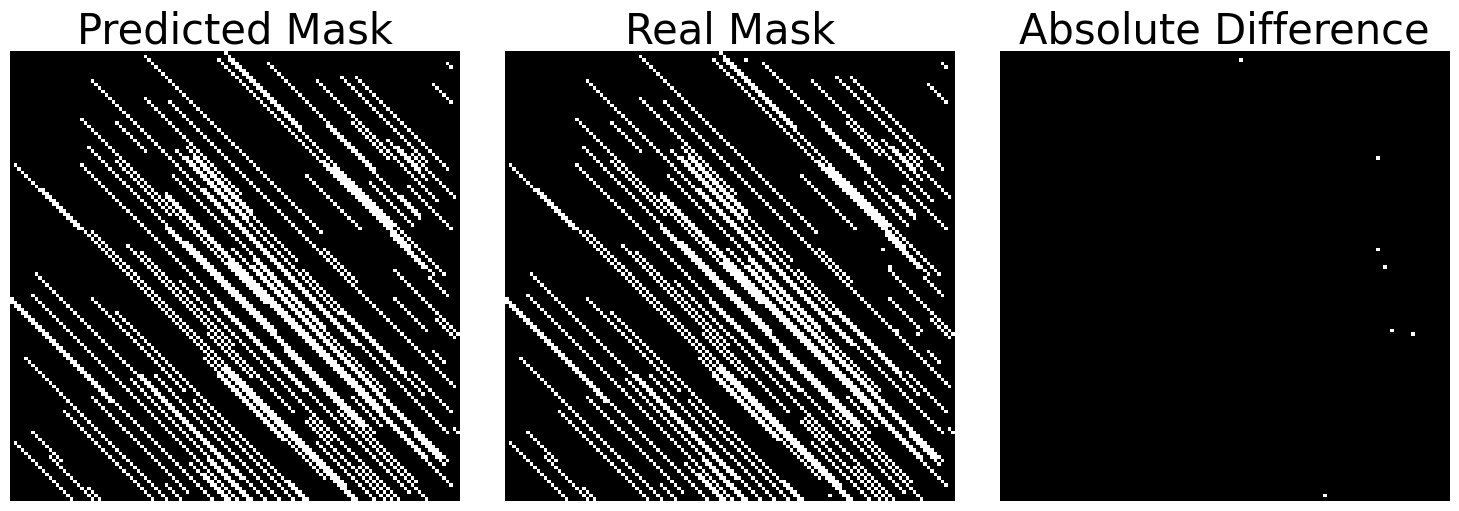

Classifier 3 - Accuracy: 0.9993896484375, Seed: 2440749822, Noise Type: periodic_noise, Window Type: window_3x3


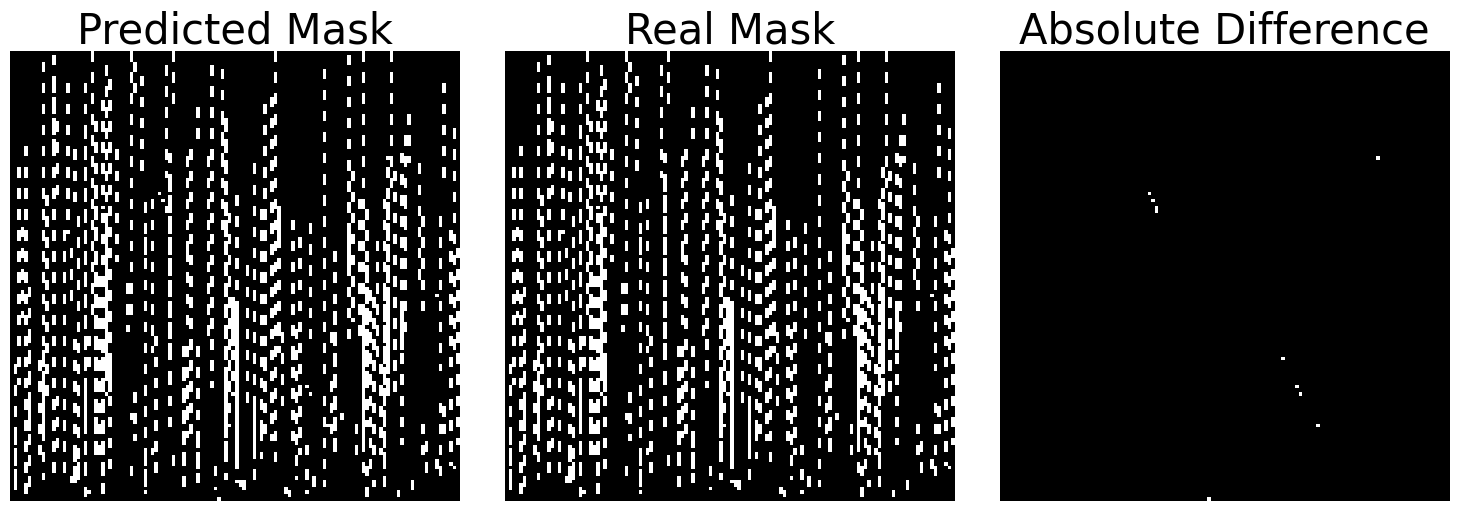

Classifier 4 - Accuracy: 0.9991455078125, Seed: 2802942914, Noise Type: sap_noise, Window Type: window_3x3


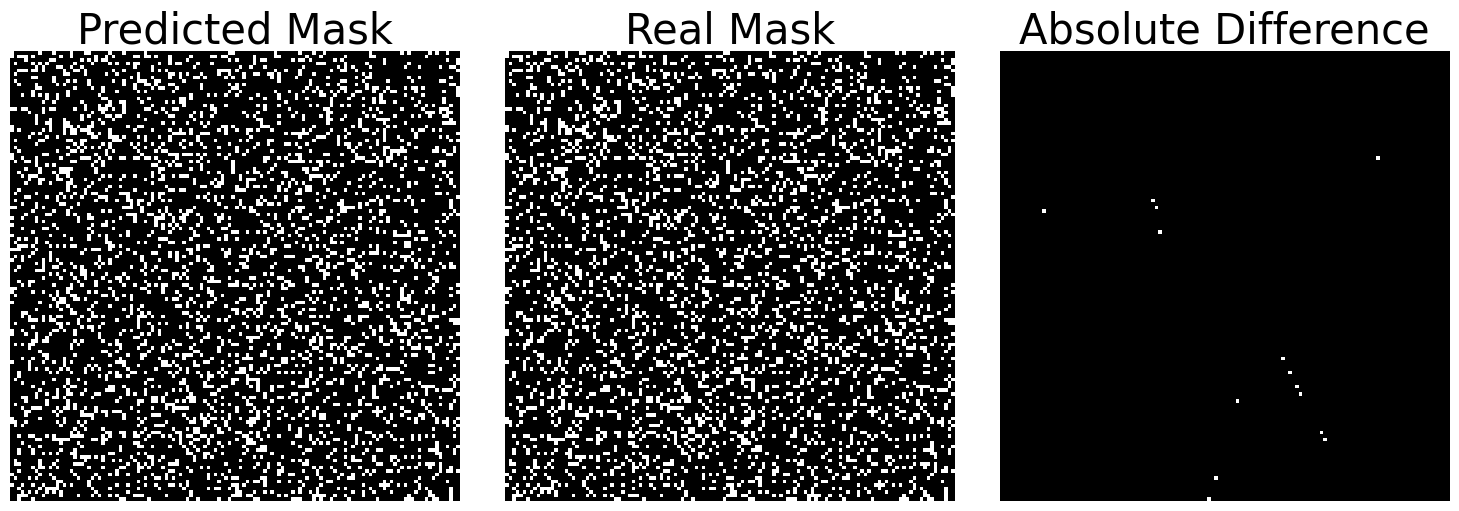

In [27]:
# import all results from results directory

classifier_stats_header = ['seed', 'noise_type', 'window_type', 'mutation_rate', 'total_evaluations', 'accuracy', 'precision', 'recall']
def import_top_results(results_dir):
    top_results = []

    classifier_results_summary = pd.read_csv(os.path.join(results_dir, 'classifier_stats.csv'), names=classifier_stats_header)
    top_vertical = classifier_results_summary[classifier_results_summary["noise_type"] == "vertical_noise"].nlargest(1, 'accuracy')['seed'].values[0]
    top_diagonal = classifier_results_summary[classifier_results_summary["noise_type"] == "diagonal_noise"].nlargest(1, 'accuracy')['seed'].values[0]
    top_periodic = classifier_results_summary[classifier_results_summary["noise_type"] == "periodic_noise"].nlargest(1, 'accuracy')['seed'].values[0]
    top_sap = classifier_results_summary[classifier_results_summary["noise_type"] == "sap_noise"].nlargest(1, 'accuracy')['seed'].values[0]
    for top_result_seed in [top_vertical, top_diagonal, top_periodic, top_sap]:
        # load the corresponding mask
        top_result_row = classifier_results_summary[classifier_results_summary['seed'] == top_result_seed]
        noise_type = top_result_row['noise_type'].values[0]
        window_type = top_result_row['window_type'].values[0]
        accuracy = top_result_row['accuracy'].values[0]

        filename = f"results_classifier_{noise_type}_{window_type}_{top_result_seed}.pkl"
        result_detail = pickle.load(open(os.path.join(results_dir, filename), 'rb'))
        
        pred_mask = result_detail['pred_mask']
        mask = result_detail['mask']
        top_results.append({
            'seed': top_result_seed,
            'noise_type': noise_type,
            'window_type': window_type,
            'predicted_mask': pred_mask,
            'accuracy': accuracy,
            'mask': mask
        })
    return top_results


top_results = import_top_results('results')
for i in range(len(top_results)):
    # compare the predicted mask with the ground truth mask
    print(f"Classifier {i+1} - Accuracy: {top_results[i]['accuracy']}, Seed: {top_results[i]['seed']}, Noise Type: {top_results[i]['noise_type']}, Window Type: {top_results[i]['window_type']}")
    visualize_classifier(top_results[i])

Text(0, 0.5, 'Accuracy')

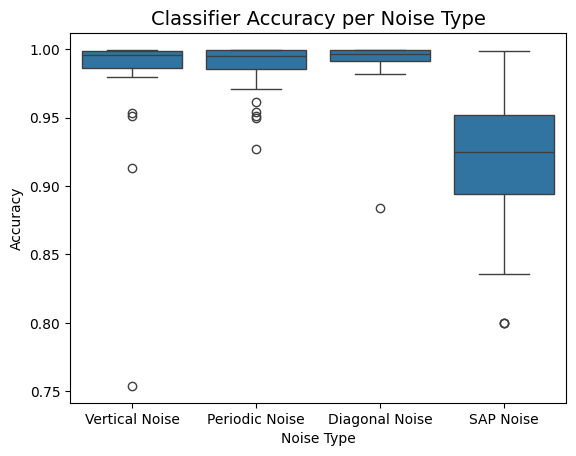

In [28]:
# Show the classifier stats as boxplot of accuracy per noise type
classifier_results_summary = pd.read_csv(os.path.join('results', 'classifier_stats.csv'), names=classifier_stats_header)
classifier_results_summary['noise_type'] = classifier_results_summary['noise_type'].replace({
    'vertical_noise': 'Vertical Noise',
    'diagonal_noise': 'Diagonal Noise',
    'periodic_noise': 'Periodic Noise',
    'sap_noise': 'SAP Noise'
})
classifier_results_summary = classifier_results_summary.query('total_evaluations == 20000')
sns.boxplot(x='noise_type', y='accuracy', data=classifier_results_summary)
plt.rc('axes', titlesize=14)
plt.title('Classifier Accuracy per Noise Type')
plt.xlabel('Noise Type')
plt.ylabel('Accuracy')

## Results from image filtering

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pickle
from scipy.ndimage import median_filter
import seaborn as sns

In [30]:
filter_stats_header = ['seed', 'noise_type', 'window_type', 'classifier_seed', 'mutation_rate', 'total_evaluations', 'fitness']

# TODO Temporary solution, waiting for all filter results to be generated 
noise_types = ['vertical_noise', 'diagonal_noise', 'periodic_noise','sap_noise']
windows_per_noise = {
    'sap_noise': ['window_3x3'],
    'periodic_noise': ['window_3x3', 'window_for_vertical'],
    'vertical_noise': ['window_3x3', 'window_for_vertical'],
    'diagonal_noise': ['window_3x3', 'window_for_diagonal'],
    }

In [31]:
def compare_images(filter_info):
    original = filter_info['original_image']
    noised = filter_info['noised_image']
    filtered_images = []
    for window_filter in windows_per_noise[filter_info['noise_type']]:
        filtered_images.append(filter_info[f'{window_filter}_filtered'])
    median_filtered_image = filter_info['median_filtered_image']
    window_type_translation = {
        'window_3x3': 'Window 3x3',
        'window_for_vertical': 'Window for Vertical',
        'window_for_diagonal': 'Window for Diagonal',
    }
    # using matplotlib to visualize the images
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 5))
    ax1.imshow(noised, cmap='gray')
    ax1.set_title(f'Noised Image')
    ax1.axis('off')
    ax2.imshow(median_filtered_image, cmap='gray')
    ax2.set_title('Median Filtered Image')
    ax2.axis('off')
    ax3.imshow(filtered_images[0], cmap='gray')
    ax3.set_title(f'CGP Filtered Image')
    ax3.axis('off')
    if len(filtered_images) > 1:
        ax4.imshow(filtered_images[1], cmap='gray')
        ax4.set_title(f'CGP Filtered Image')
        ax4.axis('off')
    else:
        ax4.axis('off')

    ax5.imshow(original, cmap='gray')
    ax5.set_title('Original Image')
    ax5.axis('off')
    plt.tight_layout()
    # set suptitle font size, not axes


    plt.show()

2705188876
2827748156
2869322905
2916408004
2861576122
2873057550
2827561776


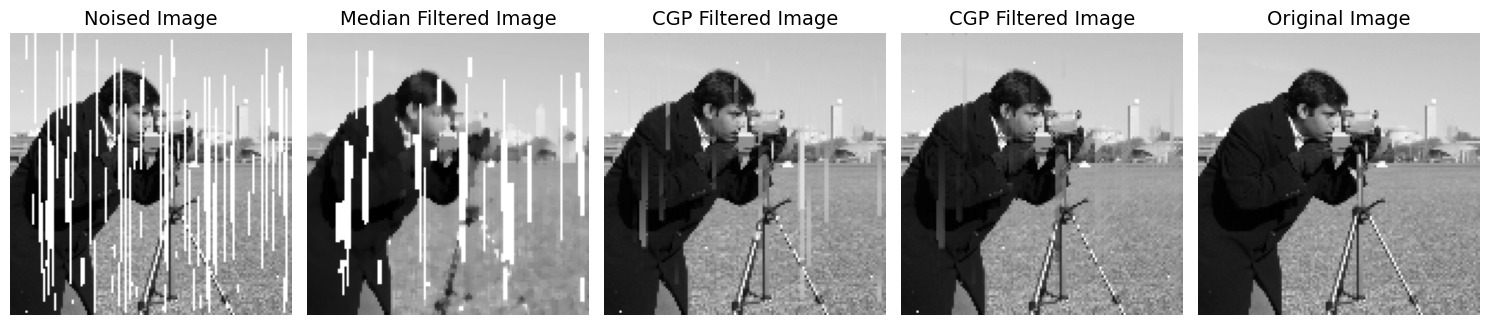

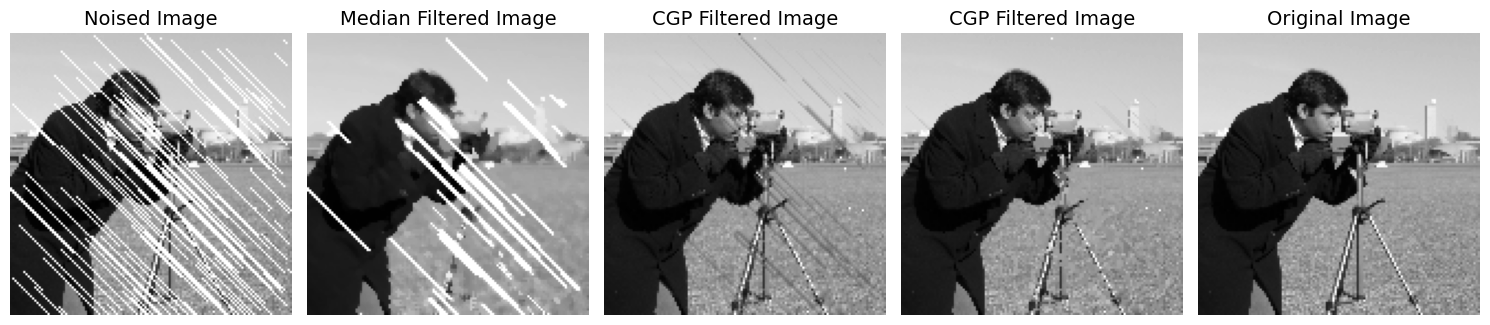

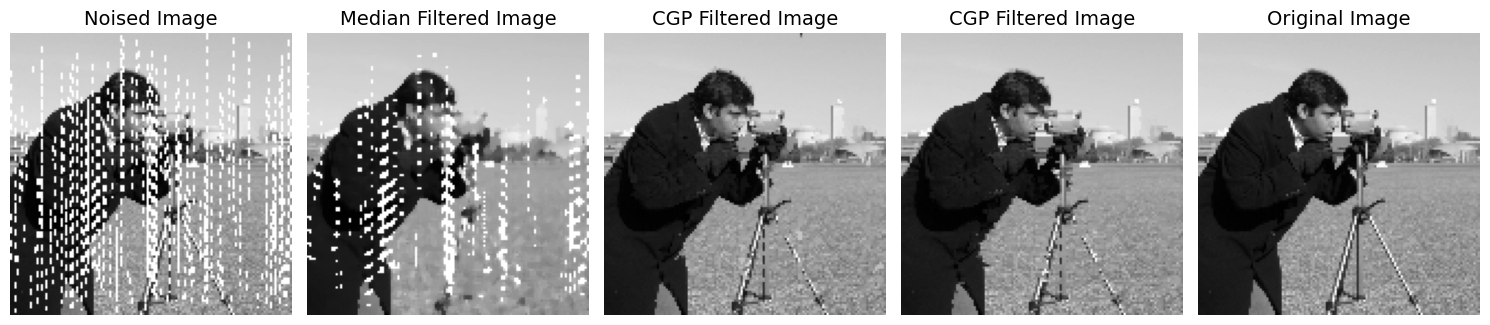

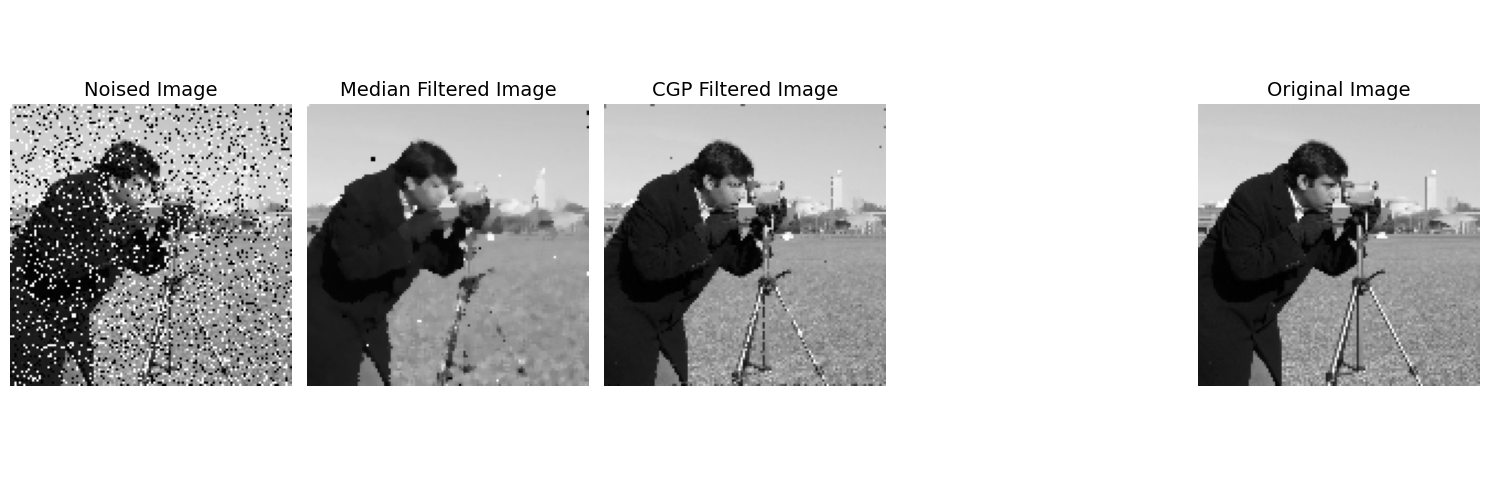

In [32]:
# change values after all filter results are generated
def import_top_filter_results(results_dir):
    top_result_seeds = []
    top_results = {}
    filter_results_summary = pd.read_csv(os.path.join(results_dir, 'filter_stats.csv'), names=filter_stats_header)
    for noise_type in noise_types:
        for window_type in windows_per_noise[noise_type]:
            top_result_per_noise_window = filter_results_summary.query(
                                                                    f'noise_type == "{noise_type}" and window_type == "{window_type}"'
                                                                    ).nlargest(1, 'fitness')['seed'].values[0]
            print(top_result_per_noise_window)
            top_result_seeds.append(top_result_per_noise_window)
    
    for top_result_seed in top_result_seeds:
        # load the corresponding mask
        top_result_row = filter_results_summary[filter_results_summary['seed'] == top_result_seed]
        noise_type = top_result_row['noise_type'].values[0]
        window_type = top_result_row['window_type'].values[0]
        fitness = top_result_row['fitness'].values[0]

        filename = f"results_filter_{noise_type}_{window_type}_{top_result_seed}.pkl"
        result_detail = pickle.load(open(os.path.join(results_dir, filename), 'rb'))
        
        filtered_image = result_detail['filtered_image']
        original_image = result_detail['original_image']
        noised_image = result_detail['noised_image']
        median_filtered_image = median_filter(noised_image, size=(3, 3))
        if top_results.get(noise_type) is None:
            top_results[noise_type] = {
                'seed': top_result_seed,
                'noise_type': noise_type,
                'noised_image': noised_image,
                'fitness': fitness,
                'original_image': original_image,
                'median_filtered_image': median_filtered_image
            }
        top_results[noise_type][f"{window_type}_filtered"] = filtered_image
    return top_results

results = import_top_filter_results('results')

for noise_type in noise_types:
    # compare the predicted mask with the ground truth mask
    compare_images(results[noise_type])

## Window comparison

In [36]:
from scipy.stats import mannwhitneyu

p-value for vertical_noise between window_3x3 and window_for_vertical: 3.913537976580181e-09
p-value for diagonal_noise between window_3x3 and window_for_diagonal: 0.6240694236867645
p-value for periodic_noise between window_3x3 and window_for_vertical: 0.2857647383453876


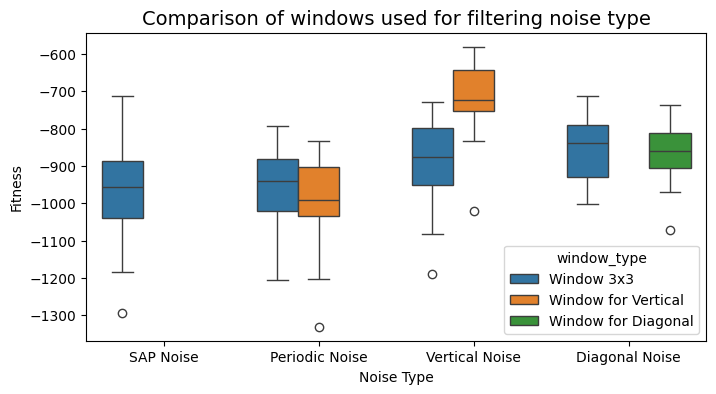

In [38]:
def plot_filter_window_comparison_boxplots(filter_results_summary):    # plot the boxplot
    filter_results_summary['noise_type'] = filter_results_summary['noise_type'].replace({
        'vertical_noise': 'Vertical Noise',
        'diagonal_noise': 'Diagonal Noise',
        'periodic_noise': 'Periodic Noise',
        'sap_noise': 'SAP Noise'
    })
    filter_results_summary['window_type'] = filter_results_summary['window_type'].replace({
        'window_3x3': 'Window 3x3',
        'window_for_vertical': 'Window for Vertical',
        'window_for_diagonal': 'Window for Diagonal',
    })
    sns.boxplot(x='noise_type', y='fitness', hue='window_type', data=filter_results_summary.query('total_evaluations == 100000'))
    plt.title(f'Comparison of windows used for filtering noise type')
    plt.xlabel('Noise Type')
    plt.ylabel('Fitness')
    # set the plot to be wider
    plt.gcf().set_size_inches(8, 4)
    plt.show()

filter_results_summary = pd.read_csv(os.path.join('results', 'filter_stats.csv'), names=filter_stats_header)

def print_p_value(filter_results_summary, noise_type, window_type_1, window_type_2):
    p_value = mannwhitneyu(
        filter_results_summary.query(f'noise_type == "{noise_type}" and window_type == "{window_type_1}"')['fitness'],
        filter_results_summary.query(f'noise_type == "{noise_type}" and window_type == "{window_type_2}"')['fitness'],
        alternative='two-sided'
    ).pvalue
    print(f"p-value for {noise_type} between {window_type_1} and {window_type_2}: {p_value}")

print_p_value(filter_results_summary, 'vertical_noise', 'window_3x3', 'window_for_vertical')
print_p_value(filter_results_summary, 'diagonal_noise', 'window_3x3', 'window_for_diagonal')
print_p_value(filter_results_summary, 'periodic_noise', 'window_3x3', 'window_for_vertical')
plot_filter_window_comparison_boxplots(filter_results_summary)    # plot the boxplot